# MEng Project

## Oct

### Oct 24th Meeting Action Items:
- [x] Always show the source signal (check for artifacts) and keep length of time for signal consistent (~3 min)
- [x] Double check fantasia source collection
   - Breathing signal collected using respiratory belt
- [x] FIX PEAK DETECTION AND INTERP (Look at paper)
   - martinez2004 is fastest and most reliable peak detection
- [x] CWT on Respiration for same 3 patients, CWT on ECG of patients
- [x] Stacked figure, resp (for signal we just looked at), ecg_env, ecg, CWT (indicate which points were used for interpolation)
- [x] Older patient
- [ ] Ask GPT about some ideas
- [ ] wavelet phase coherence between envelope and the IP signal. Because we don't care about amplitude we care about frequencies

## Nov

### Nov 7th Meeting Action Items:
 - [x] Wavelet Phase Coherence revisit code and plot with gaussian blur
- [ ] Phase Amplitude Coupling on ECG (hi freq) (should find what is the low frequency that modulates the high frequency)
- [x] Ensure window size is appropriate for each frequency and Ensure frequency range for graph is appropriate (low should cover respiratory range (varies with dataset), high should span ECG range (~1hz for R-R, Q-T is a bit slower. Stay with R-R for now.))
- [x] ML for respiration signal from ECG

### Meeting Nov 21st
- [ ] split data into train and test
- [ ] choose MARSH sample for testing. see the difference between vanilla xgb and vanilla + marsh trained data xgb
- [ ] add pink noise (establish tolerance) look at chris's paper
- [ ] wavelet phase coherence between extracted and ground truth (marija cotic paper, [here](https://onlinelibrary.wiley.com/doi/full/10.1111/epi.12918))

## January

### Meeting Jan 9th, 2024
- [x] IEEE Format, check website. 46th anual IEEE EMBC 2024
- [x] Double check that Respiration signal and "rate" are not conflated
- [x] Get PAC's PCC and coherence on Marsh Data (Adam)
- [ ] Add PCC metrics to figure 10  (Figure 3 in new paper)
- [x] Show samples of data, combined MARSH (figure 1)
- [x] Figure 7, 1 minute, with all 3 methods (Augusto) (Figure 2 in new Paper)
- [x] Summarize methods, save space for discussions.
- [x] WPC for each candidate A ONLY (no IMF stuff) against the ground truth.
- [ ] t-test between methods
- [x] Normalized graph (include in text)
- [x] Use annotated peaks (if time permits)
- [x] Remove IMF stuffs

### Meeting Jan 22nd, 2024
- [x] Figures from the same subject, same time segment (subject 0023, minute 1:00-2:00)
- [x] same # of segments, same # of patients. Align completely
- [x] send adam ALL the ECG envelope data.
- [x] Take 2 chirp signals + AWGN, CWT, WPC them and validate if PC_norm or PC is better.
- [x] Deep dive into a single sample (7113) to debug our approach for one minute, and two minute combinations
- [x] See if there is a difference between results for all minute 1's, minute 2's, minute 3's.
- [x] Once we have the results, find a sample for our comparison plot that is representative of the results.
- [x] Remove IMF from figure 3 in paper.
- [x] Take out bottom subfigure for ECG/IP example to highlight the PAC motivation

### Meeting Jan 29th, 2024
- [ ] Take out all mentions of PCC
- [x] Error bars for WPC graph
- [x] Get plot 6 color consistency (ECG Blue, PAC Orange) and use those colors in the bar graph
- [ ] Discussion points

## Feb

### Meeting Feb 26th
- [x] Set up infrastructure for ML experiment tracking
- [x] Retrain Models on first 3 minutes

## March

### Meeting March 4th AND 11th
- [ ] Reliability of IP versus Respiratory Belt
- [ ] Get score of WPC of 10s, 20s
- [ ] Deep Learning
- [ ] See if leaving out bad examples helps
- [x] Analyze from 420s to 480s with 0.133hz
- [x] Why is the WPC greater than 1 sometimes? Reimplement?
- [ ] Estimation statistics, comparing instantaneous frequencies between prediction/ground truth to also estimate the goodness of results next to WPC. We can't use straight lines for these nonlinear systems

## April

### Meeting April 15th
- [x] Fig. 1: Reduce line thickness, align axes. Aim for 300 DPI, as svg
- [x] Find a ground truth signal for figure 1 where the amplitudes are more uniform (subject 0047, minute 1. crop to valid points)
- [x] replace fig 1 w/ corresponing subject (all 300 DPI)

## May Notes

### Meeting May 2nd
- [ ] Grant for SGS (ask Adam)
- [x] Become member of IEEE 
- [x] Become member of EMBC
- [x] Register for conference
- [x] Fix figure CWT (1 plot for higher freq range and 1 for lower freq range) 
- [x] Resume ML results
- [x] Crop 79 to 92 s for figure 1

### Meeting May 9th
- [x] Check I have access to cuda cluster, canada compute
- [x] Change skip size
- [x] Change batch size
- [~] improve infrastructure

### Meeting May 17th & May 23rd
- [x] Stride 1 batch 128
- [x] test batch 256
- [x] Change transform order
- [x] doubling of window size from 256 to 512 (2 seconds to capture 10 repetitions)

## June Notes

### Meeting June 3rd and 4th

- [x] Go over the training code and how it works (dataloaders, and batches and how they go into the transformer model)
- [x] create high-level structure for copying code out of this notebook. How many, and which files do we need?
- [x] Next time: go over high level structure, go over training process more in depth, start copying code over
- [x] Go over niagara requirements and limitations for running jobs

Samuel:
- [ ] GET EVAL WORKING with WPC (ask berj for debrief next week)
- [ ] cleaning portion, and EDA (together)
- [ ] convert environment.yml to venv

Augusto:
- [ ] Half the embedding to see if 8722 stops producing half rhythm
- [ ] [Calculate Embedding Dimension for multiple input samples](https://neuropsychology.github.io/NeuroKit/functions/complexity.html#complexity-dimension) then use the average signal embedding dimension as the transformer embedding dimension.
- [ ] filtfilt lowpass for ECG
- [ ] Add envelope and compare models w/ and w/o the envelope
- [ ] Explainability (https://docs.fast.ai/interpret.html)

IF time permits:
- [ ] Investigate simpler sequence modelling techniques

## Adam PAC Data

In [82]:
from scipy.io import loadmat
# X7113 = loadmat('../MARSH/subj7113_cwt_respiration.mat')
# plt.plot(X7113['pt7113'].T)

loaded_data = loadmat('../MARSH/extracted.mat')
PAC_signals = loaded_data['extracted_signals']
PAC_subjects = loaded_data["subject_numbers"]
PAC_ids = loaded_data["extracted_signal_ids"]

## Scipy, EMD, and numpy Transforms

In [2]:
import scipy
from scipy.signal import butter, filtfilt, detrend
from PyEMD import EMD, EEMD
import neurokit2 as nk
import numpy as np
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

def FFT(x, fs=250, cutoff=np.inf):
    X = np.fft.fft(x)
    F = np.fft.fftfreq(x.shape[0], d=1/fs)
    return F[(F>0) & (F<cutoff)], abs(X[(F>0) & (F<cutoff)])

# Function to design a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply the bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to design a Butterworth lowpass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Function to apply the lowpass filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
def get_signal_extrema(signal, maxima=True):
    """
    """
    
    # 1st derivative, if close to zero, then the point is an extrema
    dxdt = np.diff(signal, prepend=signal[0])
    atol = (signal.max()-signal.min())*1e-3
    # print("Min Diff and tolerance", abs(dxdt[1:]).min(), atol)

    # 2nd der, if negative, point is concave down, else concave up
    dx2dt2 = np.diff(dxdt, prepend=dxdt[0])

    # check if extrema, concave down, and positive signal
    if maxima:
        peak_bools = np.isclose(dxdt, 0, atol=atol) & (dx2dt2 < 0) & (signal > 0)
    # check if extrema, concave up, and negative signal
    else:
        peak_bools = np.isclose(dxdt, 0, atol=atol) & (dx2dt2 > 0) & (signal < 0)
        
    peak_idxs = np.arange(signal.shape[0])[peak_bools]
    
    # ensure distance between peak idxs at least 2x0.55 hz worth of samples
    filter = np.diff(peak_idxs, prepend=peak_idxs[0]-1) >= 250/0.55 # REMOVED (2*0.55)
    peak_idxs = peak_idxs[filter]
    
    peaks = signal[peak_idxs]
    return peak_idxs, peaks


def zero_crossings(signal):
    raise NotImplementedException
    return
    # return np.where(np.diff(np.sign(signal)))[0]

def ins_freqs(signal, ref_pts, fs=250): # REMOVED FIRST ARG
# def ins_freqs(ref_pts, fs=250):
    """
    Args:
    - signal: input signal
    - ref_pts: refrence_points. the intervals between these points will be used to calculate the instantaneous frequencies
    """
    wavelengths = np.diff(ref_pts)
    return ref_pts/fs, fs/wavelengths

def eval(t_gt, if_gt, t_est, if_est, plot=False):
    """
    t_gt, if_gt: time and instantaneous frequencies from ground truth
    t_est, if_est: time and instantaneous frequencies from estimated breathing signal
    """
    
    alignment = np.abs(
        (t_gt[1:, np.newaxis]-t_est[1:])
    ).argmin(axis=1)
    if plot:
        plt.plot(
            [0, 1],
            [0, 1],
            '-'
        )
        plt.plot(
            if_gt,
            if_est[alignment],
            'bo'
        )
        plt.xlabel('Ground Truth Instantaneous Frequencies')
        plt.ylabel('Estimate Instantaneous Frequencies')
        plt.legend()
        plt.show()

    return if_gt.mean(), if_est[alignment].mean()

In [83]:
from Data import MarshData, FantasiaData
from Transforms import WPC
import Transforms
from Signal import Signal

marsh_dataset = [
    MarshData(f"../MARSH/{i}/") for i in os.listdir("../MARSH/") if len(i) == 4
]

exclusion_list = [
    ('1436', 2),
    ('0046', 0),
    ('2655', 0),
    ('2655', 2),
    ('0048', 2),
    ('0037', 1),
    ('5329', 0)
]

m1 = MarshData("../MARSH/0023/")
m2 = MarshData("../MARSH/7113/")
m_0047 = MarshData("../MARSH/0047/")

ECG shape:  (1, 224927)
ECG_annot shape:  (1, 1246)
IP shape:  (1, 224927)
IP_annot shape:  (1, 212)
NASAL shape:  (1, 899701)
NASAL_annot shape:  (1, 212)
PPG shape:  (449850, 1)
ECG shape:  (1, 227732)
ECG_annot shape:  (1, 1116)
IP shape:  (1, 227732)
IP_annot shape:  (1, 218)
NASAL shape:  (1, 910929)
NASAL_annot shape:  (1, 221)
PPG shape:  (455465, 1)
ECG shape:  (1, 228291)
ECG_annot shape:  (1, 1438)
IP shape:  (1, 228291)
IP_annot shape:  (1, 220)
NASAL shape:  (1, 913157)
NASAL_annot shape:  (1, 221)
PPG shape:  (456578, 1)
ECG shape:  (1, 226954)
ECG_annot shape:  (1, 994)
IP shape:  (1, 226954)
IP_annot shape:  (1, 132)
NASAL shape:  (1, 907809)
NASAL_annot shape:  (1, 129)
PPG shape:  (453904, 1)
ECG shape:  (1, 226609)
ECG_annot shape:  (1, 1299)
IP shape:  (1, 226609)
IP_annot shape:  (1, 182)
NASAL shape:  (1, 906429)
NASAL_annot shape:  (1, 181)
PPG shape:  (453214, 1)
ECG shape:  (1, 224380)
ECG_annot shape:  (1, 1351)
IP shape:  (1, 224380)
IP_annot shape:  (1, 208)


In [5]:
marsh_transforms = [Transforms.Crop(start=60, end=120), Transforms.MinMaxScale()]
# fig = m1.ECG().transform(transforms=marsh_transforms).plot(transformed=True)
# fig = m1.IP().transform(transforms=marsh_transforms).plot(base_fig=fig, transformed=True)
# fig = m1.ECG_ENV().transform(transforms=marsh_transforms).plot(base_fig=fig, transformed=True)
# fig.update_layout(plot_bgcolor='white')
# fig.show()

## Marsh Data Plot (fig 1)
fig 1 in paper uses 60-120 crop, in the poster for TOBE it uses 79-92s crop

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# # fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
x = m_0047.ECG().transform(transforms=[Transforms.Crop(start=79, end=92), Transforms.MinMaxScale()]).transformed_data
# x -= x.mean()
F = np.fft.fft(x)
freq = np.fft.fftfreq(x.shape[0], d=1/250)
# # ax.plot(60 + np.arange(0, x.shape[0]/250, 1/250), x) # because crop starts  60 seconds into recording
# # ax.set_xlabel("time (s)")
# # ax.set_ylabel("Normalized Amplitude")
# # ax.set_title("MARSH: Sample ECG")

fig1 = go.Figure(
    data = [go.Scatter(
        x = 79 + np.arange(0, x.shape[0]/250, 1/250), 
        y = x,
        marker=dict(color="rgb(124,218,252)")
    )]
)
fig1.update_layout(
    xaxis_title="Time (s)",
    yaxis_title="Normalized Amplitude",
    # title="MARSH: Sample ECG"
)
fig1.update_layout(
    font=dict(
        size=18,  # Set the font size here
    ),
    plot_bgcolor='white', height=480, width=680, showlegend=False, font_family='Arial', margin=dict(l=20, r=20, t=20, b=20)
)
fig1.update_xaxes(showline=True, linecolor='black', linewidth=1)
fig1.update_yaxes(showline=True, linecolor='black', linewidth=1)
fig1.show()
fig1.write_image("paper_res/poster_img_fig1_cropped.svg")

# x = m1.IP().transform(transforms=marsh_transforms).transformed_data
# x -= x.mean()
# F = np.fft.fft(x)
# freq = np.fft.fftfreq(x.shape[0], d=1/250)
# ax[1].plot(np.arange(0, x.shape[0]/250, 1/250), np.convolve(np.ones(250)/250, x, mode='same'))
# ax[1].set_xlabel("time (s)")
# ax[1].set_title("MARSH: Smoothed Sample IP")
# plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=freq[freq > 0],
        y=abs(F[freq > 0])
    )
)
fig.update_layout(height=600, width=600)
fig.show()

## Transforms Definition

In [84]:
NUM_MINUTES = 3
pipeline = [
        lambda x: x-x.mean(),
        lambda x: detrend(x),
        lambda x: np.convolve(np.ones(100)/100, x, mode='same') # exclude for method A
]
lo, hi, res = 0.1, 0.55, 60
CWT = Transforms.CWT(plot=True, lower_bound=lo, higher_bound=hi, resolution=res)

# different crops per minute
# no smoothing
method_A_transforms = [
    [Transforms.Crop(start=60*i, end=60*(i+1))] + pipeline for i in range(NUM_MINUTES)
]

gt_transforms = [
    [Transforms.Crop(start=60*i, end=60*(i+1))] + pipeline for i in range(NUM_MINUTES)
]

# define bands over which to calculate coherence
freq_band = np.linspace(lo, hi, res)

SAMPLE_RATE_CWT = 250

#### Freq Ranges for Split CWT Image (poster image)

In [7]:
# for poster image
lo_freq_ecg_lo, lo_freq_ecg_hi = 0.1, 0.55
lo_freq_ecg_CWT = Transforms.CWT(plot=False, lower_bound=lo_freq_ecg_lo, higher_bound=lo_freq_ecg_hi, resolution=res)

hi_freq_ecg_lo, hi_freq_ecg_hi = 1, 2
hi_freq_ecg_CWT = Transforms.CWT(plot=False, lower_bound=hi_freq_ecg_lo, higher_bound=hi_freq_ecg_hi, resolution=res)

|Noise $\sigma$ | PC Norm | PC |
|  --- |  --- |  --- |
| 0 | 1.0000 | 1.0000 |
| 0.0125 | 0.9836 | 0.9859 |
| 0.025 | 0.9699 | 0.9748 |
| 0.05 | 0.9429 | 0.9531 |
| 0.1 | 0.8978 | 0.9114 |
| 0.5 | 0.7141 | 0.7361 |

#### Peak detection POC

In [ ]:
f_ex = 0.52
t_ex = np.arange(0, 60, 1/250)
x_ex = np.sin(2*np.pi*f_ex*t_ex)
peak_idxs_ex, peaks_ex = get_signal_extrema(x_ex, maxima=True)  
assert np.all(np.isclose(ins_freqs(None, peak_idxs_ex)[1], f_ex, atol=0.01))
plt.plot(np.arange(0, x_ex.shape[0]/250, 1/250), x_ex)
plt.plot(peak_idxs_ex/250, x_ex[peak_idxs_ex], 'rx')
plt.show()

## Make Figure 2

In [ ]:
# def cwt_from_coeffs(coefficients, lo, hi, res):
    

from plotly.subplots import make_subplots

for idx in tqdm(range(len(marsh_dataset))):
    if idx != 24:
        continue
        
    for minute in range(3):
        fp = marsh_dataset[idx].ECG().filepath.split('/')[-2]

        # if remove when done
        
        print(f"========================================================= Idx: {idx}, Subject: {fp}, minute: {minute+1} =========================================================")
        if (fp, minute) in exclusion_list:
            print("SKIPPING")
            continue

        # ------------------------------------------ METHOD A ------------------------------------------
        # COMPARE WITH PEARSON
        x_A = marsh_dataset[idx].ECG_ENV().transform(transforms=method_A_transforms[minute])
        y = marsh_dataset[idx].IP().transform(transforms=gt_transforms[minute])
        # convert PAC signal to usable format, then run CWT for WPC
        try:
            match = np.where(
                (PAC_ids == np.array([np.where(PAC_subjects == fp)[0].item(), minute])).sum(axis=1) == 2
            )[0].item()
            
            candB = PAC_signals[match]
            x_B = Signal(_type='IP', data=candB, format='mat', filepath=None)
            
            x_B.transform(transforms=method_A_transforms[minute] + [CWT])
            x_A.transform(transforms=method_A_transforms[minute] + [CWT])
            y.transform(transforms=method_A_transforms[minute] + [CWT])
            
            x_B = x_B.transform(transforms=method_A_transforms[minute] + [Transforms.MinMaxScale()]).transformed_data[200:]
            x_A = x_A.transform(transforms=method_A_transforms[minute] + [Transforms.MinMaxScale()]).transformed_data[:x_B.shape[0]]
            y = y.transform(transforms=method_A_transforms[minute] + [Transforms.MinMaxScale()]).transformed_data[:x_B.shape[0]]
        
#             fig = make_subplots(rows=3, cols=1)
#             fig.add_trace(
#                 go.Scatter(
#                     x = 60+np.arange(0, x_A.shape[0], 1/250),
#                     y = x_A,
#                     marker=dict(color='rgb(195,131,74)'),
#                     line=dict(width=2),
#                     name='ECG Envelope Signal',
#                 ), row=1, col=1
#             )
#             fig.add_trace(
#                 go.Scatter(
#                     x = 60+np.arange(0, x_B.shape[0], 1/250),
#                     y = x_B,
#                     marker=dict(color='rgb(73,131,73)'),
#                     line=dict(width=2),
#                     name='PAC Signal'
#                 ), row=2, col=1
#             )
            
#             fig.add_trace(
#                 go.Scatter(
#                     x = 60+np.arange(0, y.shape[0], 1/250),
#                     y = y,
#                     # marker=dict(color='rgb(68,112,143)'), #original
#                     marker=dict(color='rgb(124, 218, 252)'),
#                     line=dict(width=2),
#                     name='IP Signal'
#                 ), row=3, col=1
#             )
#             fig.update_layout(showlegend=False,plot_bgcolor='white', width=600, height=600, margin=dict(l=50, r=50, t=50, b=50), font=dict(size=18))
#             fig.update_xaxes(showline=True, linewidth=1, linecolor='black', range=[60,120])
#             fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
#             fig.update_xaxes(title_text='Time (s)', row=3, col=1)
#             fig.update_yaxes(title_text="Normalized Signal Amplitude", row=2, col=1)
            
#             fig.show()
            
            
            
            # POSTER IMAGE
            hi_cwt_coefficients = marsh_dataset[idx].ECG().transform(transforms=method_A_transforms[minute] + [hi_freq_ecg_CWT]).transformed_data
            lo_cwt_coefficients = marsh_dataset[idx].ECG().transform(transforms=method_A_transforms[minute] + [lo_freq_ecg_CWT]).transformed_data
            
            
            fig, ax = plt.subplots(nrows=2, figsize=(9, 6))
            fig.suptitle("ECG CWTs Subject 0047")
            ax[0].imshow(
                np.abs(hi_cwt_coefficients)[::-1, :],  # flip axis
                aspect='auto',
                extent=[60+0, 60+hi_cwt_coefficients.shape[1]/250, hi_freq_ecg_lo, hi_freq_ecg_hi], 
                interpolation='bilinear',
                vmax=9.5e-05
            )
            
            ax[0].set_xlabel("Time (s)")
            ax[0].set_ylabel("Freq (hz)")
            ax[0].set_title(f'Top Frequencies')
            
            ax[1].imshow(
                np.abs(lo_cwt_coefficients)[::-1, :],  # flip axis
                aspect='auto',
                extent=[60+0, 60+lo_cwt_coefficients.shape[1]/250, lo_freq_ecg_lo, lo_freq_ecg_hi], 
                interpolation='bilinear',
                vmax=3e-04
            )
            
            ax[1].set_xlabel("Time (s)")
            ax[1].set_ylabel("Freq (hz)")
            ax[1].set_title(f'Bottom Frequencies')
            fig.tight_layout()
            fig.show()
            
        except (ValueError, ZeroDivisionError):
            pass

# fig.write_image("paper_res/fig2.svg")


## Pipeline Comparison. SKIP

In [ ]:
most_prominent_freqs_A = []
most_prominent_freqs_B = []
# normalized phase coherences
WPC_scores_A = []
WPC_scores_B = []
# non normalized
WPCs_A = []
WPCs_B = []

# mean instantaneous frequencies, ground truth
mean_ifs_gt_A = []
mean_ifs_gt_B = []
# mean IF's of estimated signal
mean_ifs_est_A = []
mean_ifs_est_B = []

for idx in tqdm(range(len(marsh_dataset))):
    for minute in range(3):
        fp = marsh_dataset[idx].ECG().filepath.split('/')[-2]

        # if remove when done
        
        print(f"========================================================= Subject: {fp}, minute: {minute+1} =========================================================")
        if (fp, minute) in exclusion_list:
            print("SKIPPING")
            continue

        # ------------------------------------------ METHOD A ------------------------------------------
        # COMPARE WITH WAVELET PHASE COHERENCE
        candA = marsh_dataset[idx].ECG_ENV().transform(transforms=method_A_transforms[minute] + [CWT]).transformed_data
        gtA = marsh_dataset[idx].IP().transform(transforms=gt_transforms[minute] + [CWT]).transformed_data
        
        t_A, PC_norms_A, PC_A = WPC(candA, gtA, freq=freq_band)
        
        avg_wpc_per_freq_A = PC_norms_A.mean(axis=1)
        most_prominent_freqs_A.append(
            freq_band[avg_wpc_per_freq_A.argmax()]
        )
        WPC_scores_A.append(
            PC_norms_A.mean() # is a single value, averaging over time and frequency
        )
        WPCs_A.append(
            PC_A.mean()
        )
        print("Method A freq, WPC norm, WPC not-norm", most_prominent_freqs_A[-1], WPC_scores_A[-1], WPCs_A[-1])

        # COMPARE WITH PEARSON
        x_A = marsh_dataset[idx].ECG_ENV().transform(transforms=method_A_transforms[minute]).transformed_data
        peak_idxs_A, peaks_A = get_signal_extrema(x_A, maxima=False)  
        
        y = marsh_dataset[idx].IP().transform(transforms=gt_transforms[minute]).transformed_data
        annotated_peaks = marsh_dataset[idx].IP_annot().data 
        cropped_peaks = annotated_peaks[
            (
                annotated_peaks/250 > gt_transforms[minute][0].start
            ) & (
                annotated_peaks/250 < gt_transforms[minute][0].end
            )
        ] - gt_transforms[minute][0].start*250 # adjust indices to reference the start of the transformed data, not the raw data

        mean_if_gt_A, mean_if_est_A = eval(*ins_freqs(y, cropped_peaks), *ins_freqs(x_A, peak_idxs_A))
        mean_ifs_gt_A.append(mean_if_gt_A)
        mean_ifs_est_A.append(mean_if_est_A)
        print(f"Mean IF of IP: {mean_ifs_gt_A[-1]}, Mean IF of estimate: {mean_ifs_est_A[-1]}")

        # ------------------------------------------ METHOD B ------------------------------------------
        try:
            match = np.where(
                (PAC_ids == np.array([np.where(PAC_subjects == fp)[0].item(), minute])).sum(axis=1) == 2
            )[0].item()
            
            candB = PAC_signals[match]
            # convert PAC signal to usable format, then run CWT for WPC
            x_B = Signal(_type='IP', data=candB, format='mat', filepath=None)
            t_B, PC_norms_B, PC_B = WPC(CWT(x_B), gtA, freq=freq_band)

            avg_wpc_per_freq_B = PC_norms_B.mean(axis=1)
            
            most_prominent_freqs_B.append(
                freq_band[avg_wpc_per_freq_B.argmax()]
            )
            WPC_scores_B.append(
                PC_norms_B.mean() # is a single value, averaging over time and frequency
            )
            WPCs_B.append(
                PC_B.mean()
            )
            print("Method B freq, WPC norm, WPC not-norm", most_prominent_freqs_B[-1], WPC_scores_B[-1], WPCs_B[-1])
    
            # COMPARE WITH PEARSON
            peak_idxs_B, peaks_B = get_signal_extrema(candB, maxima=True)  
            
            mean_if_gt_B, mean_if_est_B = eval(*ins_freqs(y, cropped_peaks), *ins_freqs(candB, peak_idxs_B))
            mean_ifs_gt_B.append(mean_if_gt_B)
            mean_ifs_est_B.append(mean_if_est_B)
            print(f"Mean IF of IP: {mean_ifs_gt_B[-1]}, Mean IF of estimate: {mean_ifs_est_B[-1]}")
        
        except ValueError:
            print("PAC Match not found")
                
            most_prominent_freqs_B.append(None)
            WPC_scores_B.append(None)
            WPCs_B.append(None)
            mean_ifs_gt_B.append(None)
            mean_ifs_est_B.append(None)

## Plot minute 7, guided breathing at 0.133hz

In [ ]:
metronome_7_min_transforms = [Transforms.Crop(start=60*7, end=60*(7+1))] + pipeline
marsh_dataset[idx].IP().transform(transforms=metronome_7_min_transforms).plot(transformed=True)

In [ ]:
marsh_dataset[idx].ECG_ENV().transform(transforms=metronome_7_min_transforms).plot(transformed=True)

In [ ]:
import seaborn as sns
idx=4
candA = marsh_dataset[idx].ECG_ENV().transform(transforms=metronome_7_min_transforms + [CWT]).transformed_data
gtA = marsh_dataset[idx].IP().transform(transforms=metronome_7_min_transforms + [CWT]).transformed_data
t_A, PC_norms_A, PC_A = WPC(candA, gtA, freq=freq_band)
plt.figure(figsize=(10, 6))
sns.heatmap(PC_norms_A, xticklabels=t_A.round(2), yticklabels=freq_band.round(2))
plt.show()

In [ ]:
base_fig = marsh_dataset[idx].ECG_ENV().transform(transforms=method_A_transforms[1] + [lambda x: -1*x]).plot(transformed=True)
base_fig = marsh_dataset[idx].IP().transform(transforms=method_A_transforms[1]).plot(transformed=True, base_fig=base_fig)
base_fig.show()

In [ ]:
import pandas as pd
subject_ids = []
minutes = []
for idx in tqdm(range(len(marsh_dataset))):
    for minute in range(3):
        fp = marsh_dataset[idx].ECG().filepath.split('/')[-2]
        if (fp, minute) in exclusion_list:
            continue
        subject_ids.append(fp)
        minutes.append(minute)
        
results_df = pd.DataFrame({
    "subject_id": subject_ids,
    "minute": minutes,
    "WPC_scores_A": WPC_scores_A,
    "WPC_scores_B": WPC_scores_B,
    "WPCs_A_non_normalized": WPCs_A,
    "WPCs_B_non_normalized": WPCs_B,
    "mean_ifs_gt_A": mean_ifs_gt_A,
    "mean_ifs_est_A": mean_ifs_est_A,
    "mean_ifs_gt_B": mean_ifs_gt_B,
    "mean_ifs_est_B": mean_ifs_est_B,
})
display(results_df)
results_df.to_csv(f"PAC_ECG_ENV_results_lo_{lo}hz_hi_{hi}hz.csv", index=False)

In [ ]:
filtered_results_df = results_df[~results_df.WPC_scores_B.isna()]

## Comparing Results By Minute

In [ ]:
display(results_df.groupby(by='minute').WPCs_A_non_normalized.mean())
display(results_df.groupby(by='minute').WPCs_B_non_normalized.mean())

In [ ]:
pd.DataFrame({'Ground Truth':mean_ifs_gt_A, 'ECG Envelope':mean_ifs_est_A, "PAC": mean_ifs_est_B})

In [ ]:
print("METHOD A RESULTS")
WPC_avg_A, WPC_std_A = filtered_results_df.WPCs_A_non_normalized.mean(), filtered_results_df.WPCs_A_non_normalized.std()
print("WPC Score Avg and Std", WPC_avg_A, WPC_std_A)
mean_ifs_gt_A, mean_ifs_est_A = filtered_results_df.mean_ifs_gt_A.to_numpy(), filtered_results_df.mean_ifs_est_A.to_numpy()
plt.plot([0, 1], [0, 1], ls="--")
plt.plot(mean_ifs_gt_A, mean_ifs_est_A, 'bo')
plt.xlabel("Ground Truth Inst. Freqs")
plt.ylabel("Extracted Signal Inst. Freqs")
plt.xlim([0.05, 0.35])
plt.ylim([0.05, 0.35])
plt.show()
PCC_A = scipy.stats.pearsonr(mean_ifs_gt_A, mean_ifs_est_A)[0]
print("PCC A:", PCC_A)

In [ ]:
print("METHOD B RESULTS")
most_prominent_freqs_B, WPC_scores_B = np.array(most_prominent_freqs_B), np.array(WPC_scores_B)
WPC_avg_B, WPC_std_B = filtered_results_df.WPCs_B_non_normalized.mean(), filtered_results_df.WPCs_B_non_normalized.std()
print("WPC Score Avg and Std:", WPC_avg_B, WPC_std_B)
mean_ifs_gt_B, mean_ifs_est_B = filtered_results_df.mean_ifs_gt_B.to_numpy(), filtered_results_df.mean_ifs_est_B.to_numpy()
plt.plot([0, 1], [0, 1], ls="--")
plt.plot(mean_ifs_gt_B[mean_ifs_gt_B.astype(bool)], mean_ifs_est_B[mean_ifs_est_B.astype(bool)], 'bo')
plt.xlabel("Ground Truth Inst. Freqs")
plt.ylabel("Extracted Signal Inst. Freqs")
plt.xlim([0.05, 0.35])
plt.ylim([0.05, 0.35])
plt.show()
PCC_B = scipy.stats.pearsonr(mean_ifs_gt_B[mean_ifs_gt_B.astype(bool)], mean_ifs_est_B[mean_ifs_est_B.astype(bool)])[0]
print("PCC B:", PCC_B)

In [ ]:
mean_ifs_gt_B[mean_ifs_gt_B.astype(bool)].mean()

# Bar Plots of Results (WPC and IF)

In [ ]:
print(f"{PCC_A:.3f} & {PCC_B:.3f} & {WPC_avg_A:.3f} & {WPC_avg_B:.3f}")

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=1, subplot_titles=[''])

fig.add_trace(go.Bar(
    x=['ECG Envelope'],
    y=[WPC_avg_A],
    marker=dict(color='rgb(195,131,74)'),
    error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=[WPC_std_A],
            visible=True
    )
), row=1, col=1)
fig.add_trace(go.Bar(
    x=['PAC'],
    y=[WPC_avg_B],
    marker=dict(color='rgb(73,131,73)'),
    error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=[WPC_std_B],
            visible=True
    )
), row=1, col=1)

fig.update_layout(plot_bgcolor='white', height=450, width=500, showlegend=False, font_family='Arial', yaxis_title='Average WPC')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', range=[0.75, 0.975])
fig.show()

# plt.bar(
#     ['ECG Envelope', 'PAC'],
#     [WPC_avg_A, WPC_avg_B],
# )
# plt.errorbar(
#     ['ECG Envelope', 'PAC'],
#     [WPC_avg_A, WPC_avg_B],
#     [WPC_std_A, WPC_std_B],
#     fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2
# )
# plt.ylabel("Average Wavelet Phase Coherence")
# plt.ylim([0.7, 1])
# plt.show()

In [ ]:
plt.bar(
    ['ECG Envelope', 'PAC'],
    [PCC_A, PCC_B],
)
plt.ylabel("Pearson Correlation Coefficient")
plt.show()

# Paired T-test

In [ ]:
delta_df = pd.DataFrame({
    "WPC ECG ENV": filtered_results_df.WPCs_A_non_normalized, 
    "WPC PAC" : filtered_results_df.WPCs_B_non_normalized,
    "Delta": filtered_results_df.WPCs_A_non_normalized-filtered_results_df.WPCs_B_non_normalized
})

delta_df.sample(20).sort_values(by='Delta', ascending=False).style.background_gradient(cmap="RdYlGn", subset=['Delta'])

In [ ]:
print("Manual Result")
print(delta_df.Delta.mean()/(
    delta_df.Delta.std()/np.sqrt(len(delta_df))
))

In [ ]:
from scipy.stats import ttest_rel
# print(
#     ttest_rel(filtered_results_df.WPCs_A_non_normalized, filtered_results_df.WPCs_B_non_normalized, alternative='two-sided')
# )
print("Scipy Result")
print(
    ttest_rel(filtered_results_df.WPCs_A_non_normalized, filtered_results_df.WPCs_B_non_normalized, alternative='greater').statistic
)

## Figure Comparing signals produced by both methods vs Ground Truth

In [ ]:
for idx in tqdm(range(len(marsh_dataset))):
    for minute in range(3):
        fp = marsh_dataset[idx].ECG().filepath.split('/')[-2]

        # if remove when done
        
        print(f"========================================================= Subject: {fp}, minute: {minute+1} dataset idx: {idx} =========================================================")
        if (fp, minute) in exclusion_list:
            print("SKIPPING")
            continue

        # ------------------------------------------ METHOD A ------------------------------------------

        x_A = marsh_dataset[idx].ECG_ENV().transform(transforms=method_A_transforms[minute]).transformed_data
        
        y = marsh_dataset[idx].IP().transform(transforms=gt_transforms[minute]).transformed_data

        # ------------------------------------------ METHOD B ------------------------------------------
        try:
            match = np.where(
                (PAC_ids == np.array([np.where(PAC_subjects == fp)[0].item(), minute])).sum(axis=1) == 2
            )[0].item()
            
            candB = PAC_signals[match]
            # convert PAC signal to usable format, then run CWT for WPC
            x_B = Signal(_type='IP', data=candB, format='mat', filepath=None)
                        
            # Create a figure and a set of subplots
            fig, axs = plt.subplots(3, 1, figsize=(8, 5))  # width = 8 inches, height = 5 inches
            
            # Plot for Method A
            axs[0].plot(
                np.arange(0, x_A.shape[0]/250, 1/250),
                Transforms.MinMaxScale()(x_A),
                label='ECG Envelope'
            )
            axs[0].set_title('ECG Envelope')
            axs[0].grid(True)
            
            # Plot for Method B
            axs[1].plot(
                np.arange(0, candB.shape[0]/250, 1/250),
                Transforms.MinMaxScale()(candB),
                label='PAC'
            )
            axs[1].set_title('PAC')
            axs[1].grid(True)
            
            # Plot for True Signal
            axs[2].plot(
                np.arange(0, y.shape[0]/250, 1/250), 
                Transforms.MinMaxScale()(y), 
                label='True Signal'
            )
            axs[2].set_title('True Signal')
            axs[2].grid(True)
            
            # Setting the background color of the figure
            fig.patch.set_facecolor('white')
            
            # Setting the spines for each axis
            for ax in axs:
                for spine in ax.spines.values():
                    spine.set_edgecolor('black')
                    spine.set_linewidth(1)
            
            # Adjusting layout
            plt.tight_layout()
            
            # Show the plot
            plt.show()
            
        except ValueError as e:
            print("PAC Match not found")

In [ ]:
from plotly.subplots import make_subplots
# idx = 3
# minute = 1
# fp = marsh_dataset[idx].ECG().filepath.split('/')[-2]

# print(f"======================================================= Subject: {fp}, minute: {minute+1} dataset idx: {idx} =======================================================")

# # ------------------------------------------ METHOD A ------------------------------------------

# x_A = marsh_dataset[idx].ECG_ENV().transform(transforms=method_A_transforms[minute]).transformed_data

# y = marsh_dataset[idx].IP().transform(transforms=gt_transforms[minute]).transformed_data

# # ------------------------------------------ METHOD B ------------------------------------------
# match = np.where(
#     (PAC_ids == np.array([np.where(PAC_subjects == fp)[0].item(), minute])).sum(axis=1) == 2
# )[0].item()

# candB = PAC_signals[match]
# # convert PAC signal to usable format, then run CWT for WPC
# x_B = Signal(_type='IP', data=candB, format='mat', filepath=None)

fig = make_subplots(rows=3, cols=1)
fig.add_trace(
    go.Scatter(
        x = 60+np.arange(0, x_A.shape[0], 1/250),
        y = Transforms.MinMaxScale()(x_A),
        marker=dict(color='rgb(195,131,74)'),
        line=dict(width=5),
        name='ECG Envelope Signal'
    ), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x = 60+np.arange(0, x_B.data.shape[0], 1/250),
        y = Transforms.MinMaxScale()(x_B.data),
        marker=dict(color='rgb(73,131,73)'),
        line=dict(width=5),
        name='PAC Signal'
    ), row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x = 60+np.arange(0, y.shape[0], 1/250),
        y = Transforms.MinMaxScale()(y),
        # marker=dict(color='rgb(68,112,143)'), #original
        marker=dict(color='rgb(124, 218, 252)'),
        line=dict(width=5),
        name='IP Signal'
    ), row=3, col=1
)
fig.update_layout(plot_bgcolor='white', width=800, height=500)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.update_xaxes(title_text='Time (s)', row=3, col=1)
fig.update_yaxes(title_text="Normalized Signal Amplitude", row=2, col=1)

fig.show()

## Exporting ECG ENV data

In [ ]:
# exported_ecg_envs = []
# exported_fps = []
# exported_minutes = []


# for idx in tqdm(range(len(marsh_dataset))):
#     for minute in range(3):

#         fp = marsh_dataset[idx].ECG().filepath.split('/')[-2]

#         # if remove when done
        
#         print(f"========================================================= Subject: {fp}, minute: {minute+1} =========================================================")
#         if (fp, minute) in exclusion_list:
#             print("SKIPPING")
#             continue

#         exported_ecg_envs.append(marsh_dataset[idx].ECG_ENV().transform(transforms=method_A_transforms[minute]).transformed_data)
#         exported_fps.append(fp)
#         exported_minutes.append(minute)
        

In [ ]:
# from scipy.io import savemat
# export_data = {
#     "ECG_ENV": exported_ecg_envs,
#     "Subject_ID": exported_fps,
#     "Minute": exported_minutes
# }

In [ ]:
# savemat("marsh_ECG_envelopes_jan_2024.mat", export_data)

# Eval Functions (not for this paper)

In [ ]:
assert False

In [ ]:
import pandas as pd

df = pd.DataFrame({
    'Instantaneous_Frequency_CorrA': WPC_scores_A,
    'Instantaneous_Frequency_CorrB': WPC_scores_B,
    'Coherence_A': cohsA,
    'Coherence_B': cohsB,
})
df['dataset'] = ['MARSH']*29 + ['Fantasia']*28

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2, subplot_titles=['Ins. Freq Correlation', 'Avg Band Coherence'])

mean_df = df.groupby(by='dataset').mean()
fig.add_trace(go.Bar(
    x = ["Fantasia", "Marsh"],# "COHa", "COHb"],
    y = mean_df.iloc[:, 0].T, 
    name='Method A (ECG Env)',
    marker=dict(color='blue')
), row=1, col=1)
fig.add_trace(go.Bar(
    x = ["Fantasia", "Marsh"],# "COHa", "COHb"],
    y = mean_df.iloc[:, 1], 
    name='Method B (IMFs)',
    marker=dict(color='red')
), row=1, col=1)
fig.add_trace(go.Bar(
    x = ["Fantasia", "Marsh"],# "COHa", "COHb"],
    y = mean_df.iloc[:, 2].T, 
    name='Method A (ECG Env)',
    marker=dict(color='blue')
), row=1, col=2)
fig.add_trace(go.Bar(
    x = ["Fantasia", "Marsh"],# "COHa", "COHb"],
    y = mean_df.iloc[:, 3], 
    name='Method B (IMFs)',
    marker=dict(color='red')
), row=1, col=2)
fig.update_layout(plot_bgcolor='white', width=800)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()

In [ ]:
def choose_best_imf(imfs, L_br=1/16, U_br=1/8, imf_bar_plot=False, **kwargs):
    """
    Args:
    - imfs:
    - n_candidates: 
    - L_br, U_br: lower and upper bound of respiratory rate, will be used to extract the IMFs with the most 
    power in this band. Extracted from bounds established in
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7796076/#:~:text=Due%20to%20the%20displacement%20of,by%20body%20movement%2C%20including%20breathing.
    """
    w = scipy.signal.windows.tukey(imfs.shape[1], alpha=0.1)
    # proportion of power that is in the range of breathing
    band_powers = []
    for i, imf in enumerate(imfs):
        
        imf_lp = butter_lowpass_filter(w*imf, cutoff=40, fs=250, order=4)
        freqs_x, fft_x = FFT(imf_lp, cutoff=5)
        band_powers.append(
            fft_x[(freqs_x > L_br) & (freqs_x < U_br)].sum()/fft_x.sum()
        )
    if imf_bar_plot:
        plt.title("IMF Band Powers")
        plt.bar(np.arange(imfs.shape[0]), band_powers)
        plt.show()
        
    return imfs[np.argmax(band_powers)]

def plot_imfs(imfs, ip=None):
    fig, ax = plt.subplots(imfs.shape[0], 2, figsize=(10, imfs.shape[0]*2.5))
    for i, imf in enumerate(imfs):
        freqs_x, fft_x = FFT(imf, cutoff=5)
        
        ax[i, 0].set_title(f"IMF {i}")
        ax[i, 0].plot(np.arange(0, imf.shape[0]/250, 1/250), imf)
        ax[i, 1].set_title(f"Energy of Br Band: {fft_x[(freqs_x > L_br) & (freqs_x < U_br)].sum()/fft_x.sum()}")
        ax[i, 1].plot(freqs_x, fft_x)
        
        if ip is not None:
            freqs_ip, fft_ip = FFT(ip, cutoff=5)
            ax[i, 0].plot(np.arange(0, ip.shape[0]/250, 1/250), ip)
            ax[i, 1].plot(freqs_ip, fft_ip)

    plt.tight_layout()
    plt.show()

def MethodB(signal, ecg_transforms, n_candidates=2, trials=100, noise_width=0.8, **kwargs):
    x = signal.ECG().transform(transforms=ecg_transforms).transformed_data
    L_br, U_br = 1/16, 0.3
    # remove linear trend and DC
    x -= x.mean()
    x = detrend(x)
    # calculate IMFs ()
    imfs =  EEMD(trials=trials, noise_width=noise_width)(x)
    # choose best IMF()
    candidate = choose_best_imf(imfs, **kwargs)
    # return time, and best predictions
    return candidate, imfs
    

### Run On Both Datasets

In [ ]:
crop = Transforms.Crop(start=5, end=180)
resultsA = []
cohsA = []
resultsB = []
cohsB = []
for i in tqdm(range(len(marsh_dataset))):
    print(f"---------------------------- 'MARSH: SAMPLE {i}--------------------------------------------------------")
    ground_truth = marsh_dataset[i].IP().transform(transforms=[
        crop,  
        lambda x: x-x.mean(),
        lambda x: detrend(x),
        lambda x: np.convolve(np.ones(250)/250, x, mode='same') # smooth
    ]).transformed_data
    
    candA = marsh_dataset[i].ECG_ENV().transform(transforms=[
        crop,  
        lambda x: x-x.mean(),
        lambda x: detrend(x),
    ]).transformed_data
    f, CxyA = scipy.signal.coherence(candA, ground_truth)
    
    resultsA.append(eval(ground_truth=ground_truth, candidate=candA))
    cohsA.append(CxyA[(f > 1/16) & (f < 0.3)].mean())
    print(
        f"Method A: {resultsA[-1]} coherence {cohsA[-1]}"
    )
    
    # COMMENTED OUT IMF STUFF FOR LATER
    # candB, imfs = MethodB(
    #     marsh_dataset[i],
    #     ecg_transforms=[crop],
    #     trials=30,
    #     # imf_bar_plot=True
    # )
    # f, CxyB = scipy.signal.coherence(candB, ground_truth)
    
    # resultsB.append(eval(ground_truth=ground_truth, candidate=candB))
    # cohsB.append(CxyB[(f > 1/16) & (f < 0.3)].mean())
    # print(
    #     f"Method B: {resultsB[-1]} coherence {cohsB[-1]}"
    # )

In [ ]:
for i in tqdm(range(len(fantasia_dataset))):
    for j in range(7):
        crop = Transforms.Crop(start=(180*j)+5, end=180*(j+1))
        
        print(f"---------------------------- Fantasia: SAMPLE {i}, SEGMENT {j}--------------------------------------------------------")
        ground_truth = fantasia_dataset[i].IP().transform(transforms=[
            crop,  
            lambda x: x-x.mean(),
            lambda x: detrend(x),
            lambda x: np.convolve(np.ones(250)/250, x, mode='same') # smooth
        ]).transformed_data
        
        candA = fantasia_dataset[i].ECG_ENV().transform(transforms=[
            crop,
            lambda x: x-x.mean(),
            lambda x: detrend(x),
        ]).transformed_data
        f, CxyA = scipy.signal.coherence(candA, ground_truth)
        
        resultsA.append(eval(ground_truth=ground_truth, candidate=candA))
        cohsA.append(CxyA[(f > 1/16) & (f < 0.3)].mean())
        print(
            f"Method A: {resultsA[-1]} coherence {cohsA[-1]}"
        )

        # IMF STUFF COMMENTED OUT
        # candB, imfs = MethodB(
        #     fantasia_dataset[i],
        #     ecg_transforms=[crop],
        #     trials=30,
        #     # imf_bar_plot=True
        # )
        # f, CxyB = scipy.signal.coherence(candB, ground_truth)
        
        # resultsB.append(eval(ground_truth=ground_truth, candidate=candB))
        # cohsB.append(CxyB[(f > 1/16) & (f < 0.3)].mean())
        # print(
        #     f"Method B: {resultsB[-1]} coherence {cohsB[-1]}"
        # )

# ML Regressor

In [8]:
import xgboost as xgb
import scipy
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided

In [9]:
from train_utils import get_rolling_windows

def get_masks(signal, p=0.08, mask_length=125):
    return np.random.choice([0, 1], size=(signal.shape[0], mask_length), p=[1,0])

In [85]:
from sklearn.metrics import roc_auc_score, confusion_matrix
from tqdm.auto import tqdm

train_idx = 0
start_time_XGB = 0 # in seconds
end_time_XGB = 180 # in seconds

N_test = 60 # one minute of data
start_time_XGB_test = 420
train_jump_size = 10
batch_size = 128

## XGB

In [ ]:
train_fig = marsh_dataset[train_idx].ECG().transform(transforms=[
        Transforms.Crop(start_time_XGB, end_time_XGB),
        Transforms.MinMaxScale(),
        lambda x: x-x.mean(),
        lambda x: detrend(x),
    ]).plot(transformed=True)


marsh_dataset[train_idx].IP().transform(transforms=[
    Transforms.Crop(start_time_XGB, end_time_XGB),
    Transforms.MinMaxScale(),
    lambda x: x-x.mean(),
    lambda x: detrend(x),
]).plot(transformed=True, base_fig=train_fig)

train_fig.show()

## Make All Train Data (SKIP)

In [ ]:
test_idx = 8
# start_time_XGB = 240 # in seconds
# end_time_XGB = 700 # in seconds
    
WPC_per_index = []
WPC_smoothed_per_index = []
for train_idx in tqdm(range(len(marsh_dataset))):#NUM_MARSH_TRAIN_SAMPLES_XGB)):

    print("================================================================================")
    print("INDEX:", train_idx)
    # ECG input data
    X_ecg_rolling_train_stack = []
    y_ip_train_stack = []
    
    input_ecg_raw = marsh_dataset[train_idx].ECG().transform(transforms=[
        Transforms.Crop(start_time_XGB, end_time_XGB),
        Transforms.MinMaxScale(),
        lambda x: x-x.mean(),
        lambda x: detrend(x),
    ])
    
    # Breathing Rate input and target data
    input_ip_raw = marsh_dataset[train_idx].IP().transform(transforms=[
        Transforms.Crop(start_time_XGB, end_time_XGB),
        Transforms.MinMaxScale(),
        lambda x: x-x.mean(),
        lambda x: detrend(x),
    ])
    
    # rolling window parameters
    window_size = input_ecg_raw.sample_rate*4
    
    input_ecg = input_ecg_raw.transformed_data
    input_ip = input_ip_raw.transformed_data
    
    X_ecg_rolling = get_rolling_windows(input_ecg, window_size=window_size, jump=train_jump_size)
    y_ip = input_ip.data[window_size-1:][::train_jump_size]
    
    X_ecg_rolling_train_stack.append(X_ecg_rolling)
    y_ip_train_stack.append(y_ip)

    X_ecg_rolling_train_stack_np = np.vstack(X_ecg_rolling_train_stack)
    y_ip_train_stack_np = np.stack(y_ip_train_stack).flatten()
    # print(X_ecg_rolling_train_stack_np.shape, y_ip_train_stack_np.shape)
    
    # reg = xgb.XGBRegressor(tree_method="hist")
    # # Fit the model using predictor X and response y.
    # reg.fit(X_ecg_rolling_train_stack_np, y_ip_train_stack_np)


    ## Set up test data (from 420s to 480s, the controlled breathing at 0.133hz
    # ECG input data
    x_test_ecg_raw = marsh_dataset[train_idx].ECG().transform(transforms=[
        Transforms.Crop(start_time_XGB_test, start_time_XGB_test+N_test),
        Transforms.MinMaxScale(),
        lambda x: x-x.mean(),
        lambda x: detrend(x),
    ]).transformed_data
    
    x_test_ecg_rolling = get_rolling_windows(x_test_ecg_raw, window_size=window_size)
    
    y_test = marsh_dataset[train_idx].IP().transform(transforms=[
        Transforms.Crop(start_time_XGB_test, start_time_XGB_test+N_test),
        Transforms.MinMaxScale(),
        lambda x: x-x.mean(),
        lambda x: detrend(x),
    ]).transformed_data[window_size-1:]
    
    preds = []
    smoothed_preds = []
    smoothing_length = 50
    mean_filter = np.ones(smoothing_length)
    
    for xi in tqdm(x_test_ecg_rolling):
        pred = reg.predict(xi[np.newaxis, :])[0]
        preds.append(pred)
        filt_order = min(smoothing_length, len(preds))
        smoothed_preds.append(
            np.dot(preds[-filt_order:],mean_filter[-filt_order:])/filt_order # smoothed prediction
        )
    preds = np.array(preds)
    smoothed_preds = np.array(smoothed_preds)
    assert preds.shape[0] == y_test.shape[0]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(y = preds, name='pred'))
    fig.add_trace(go.Scatter(y = smoothed_preds, name='smoothed pred'))
    fig.add_trace(go.Scatter(y = y_test, name='ground truth'))
    fig.show()
    
    pred_signal = Signal(format='mat', filepath=None, _type='IP', data=np.array(preds))
    pred_smoothed_signal = Signal(format='mat', filepath=None, _type='IP', data=np.array(smoothed_preds))
    gt_signal = Signal(format='mat', filepath=None, _type='IP', data=np.array(y_test))

    pred_signal_CWT = pred_signal.transform(transforms=[CWT]).transformed_data
    pred_smoothed_signal_CWT = pred_smoothed_signal.transform(transforms=[CWT]).transformed_data
    gt_signal_CWT = gt_signal.transform(transforms=[CWT]).transformed_data
    _, _, PC_test = WPC(
        pred_signal_CWT,
        gt_signal_CWT,
    )
    _, _, PC_smoothed_test = WPC(
        pred_smoothed_signal_CWT,
        gt_signal_CWT,
    )
    
    WPC_per_index.append(PC_test.mean())
    WPC_smoothed_per_index.append(PC_smoothed_test.mean())
    
    print(f"| WPC | Smoothed WPC |")
    print(f"| {WPC_per_index[-1]:.4f} | {WPC_smoothed_per_index[-1]:.4f} |")

In [ ]:
# fig = go.Figure()
# fig.add_trace(
#     go.Bar(
#         x=np.array(range(len(WPC_per_index))), 
#         y=np.array(WPC_per_index),
#         name="WPC: Raw Prediction"
#     )
# )
# fig.add_trace(
#     go.Bar(
#         x=np.array(range(len(WPC_smoothed_per_index))), 
#         y=np.array(WPC_smoothed_per_index),
#         name="WPC: Smoothed Prediction"
#     )
# )
# fig.update_layout(
#     title='WPCs of each sample. Trained on first 3 minutes, tested on controlled breathing minute @ 0.133hz',
#     barmode='group'
# )
# fig.update_xaxes(tickvals = list(range(len(WPC_per_index))))
# fig.show()

## Transfer Learning, pretrain on best data

In [11]:
# np.argsort(WPC_smoothed_per_index)[::-1]
argsort_WPC_smoothed_per_index = [24, 19,  9,  4,  0, 23, 22,  2, 20, 25,  3, 26, 17, 13, 16,  8, 12, 10, 21, 28,  1,  5, 27,  7, 18, 14, 11,  6, 15]

In [130]:
X_ecg_rolling_train_stack = []
y_ip_train_stack = []
TRAIN_SAMPLES = 8

for train_idx in tqdm(argsort_WPC_smoothed_per_index[:TRAIN_SAMPLES]):#np.argsort(WPC_smoothed_per_index)[::-1][:4]):

    print("================================================================================")
    print("INDEX:", train_idx)
    print("Subject num", int(marsh_dataset[train_idx].data['ECG'].filepath.split('/')[-2]))
    # ECG input data
    
    input_ecg_raw = marsh_dataset[train_idx].ECG().transform(transforms=[
        Transforms.Crop(start_time_XGB, end_time_XGB), # C
        Transforms.MinMaxScale(), # S
        lambda x: x-x.mean(), # M
        lambda x: detrend(x), # D
    ])
    
    # Breathing Rate input and target data
    input_ip_raw = marsh_dataset[train_idx].IP().transform(transforms=[
        Transforms.Crop(start_time_XGB, end_time_XGB),
        Transforms.MinMaxScale(),
        lambda x: x-x.mean(),
        lambda x: detrend(x),
    ])
    
    # rolling window parameters
    window_size = input_ecg_raw.sample_rate*4
    
    input_ecg = input_ecg_raw.transformed_data
    input_ip = input_ip_raw.transformed_data
    
    X_ecg_rolling = get_rolling_windows(input_ecg, window_size=window_size, jump=train_jump_size)
    y_ip = input_ip.data[window_size-1:][::train_jump_size]
    
    X_ecg_rolling_train_stack.append(X_ecg_rolling)
    y_ip_train_stack.append(y_ip)

X_ecg_rolling_train_stack_np = np.vstack(X_ecg_rolling_train_stack)
y_ip_train_stack_np = np.stack(y_ip_train_stack).flatten()

# reg = xgb.XGBRegressor(tree_method="hist")
# # Fit the model using predictor X and response y.
# reg.fit(X_ecg_rolling_train_stack_np, y_ip_train_stack_np)

  0%|          | 0/8 [00:00<?, ?it/s]

INDEX: 24
Subject num 47
INDEX: 19
Subject num 83
INDEX: 9
Subject num 3723
INDEX: 4
Subject num 5
INDEX: 0
Subject num 5600
INDEX: 23
Subject num 8623
INDEX: 22
Subject num 1337
INDEX: 2
Subject num 5329


In [108]:
X_ecg_rolling_train_stack_np.shape, y_ip_train_stack_np.shape

((4401, 1000), (4401,))

In [ ]:
# with open('asdfasdfX_ecg_rolling_all_stack_np.npy', 'wb') as f:
#     np.save(f, asdfasdfafX_ecg_rolling_train_stack_np)
# with open('asdfasdfadsy_ip_all_stack_np.npy', 'wb') as f:
#     np.save(f, asdasdfay_ip_train_stack_np)

### Architecture: A TRANSFORMER-BASED FRAMEWORK FOR MULTIVARIATE TIME SERIES REPRESENTATION LEARNING
[Source to Code](https://timeseriesai.github.io/tsai/models.tst.html)

[Source to Paper](https://arxiv.org/pdf/2010.02803.pdf)

#### Key Points:
> At the core of our method lies a transformer encoder, as described in the original transformer work by Vaswani et al. (2017); however, we do not use the decoder part of the architecture


> We clarify that regression in the context of this work means predicting a numeric value for a given sequence (time series sample). This numeric
value is of a different nature than the numerical data appearing in the time series: for example, given a sequence of simultaneous temperature and humidity measurements of 9 rooms in a house, as well as weather and climate data such as temperature, pressure, humidity, wind speed, visibility and dewpoint, we wish to predict the total energy consumption in kWh of a house for that day



## TSAI Train Loop

### Uncomment to run on GPU

1:40 per loop on CPU for train size 8 and jump = 10

In [109]:
import os
os.environ["DEVICE"] = "cuda"

In [136]:
from tsai.all import TST, Learner, MSELossFlat, rmse, ShowGraph, get_splits, \
TSRegression, \
TSStandardize, \
get_ts_dls

# Your data preparation here
seq_len = 512 #, X_ecg_rolling_train_stack_np.shape[1]   # Length of your time series
iters = 15
lr = 3e-4

tsai_X_train = X_ecg_rolling_train_stack_np[:, -seq_len:].reshape(-1, 1, seq_len)
tsai_y_train = y_ip_train_stack_np.reshape(-1, 1)
# Create TSDataset and TSDataLoaders
splits = get_splits(tsai_y_train, valid_size=0.2, stratify=True, random_state=23, shuffle=True)
tfms  = [None, TSRegression()]
batch_tfms = TSStandardize(by_sample=True)  # Standardize data
dls = get_ts_dls(tsai_X_train, tsai_y_train, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=batch_size)

# Use a specific architecture directly, e.g., TST for ResNet-like behavior
model = TST(dls.vars, dls.c, seq_len=seq_len)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=ShowGraph())

# Train the model
learn.fit_one_cycle(iters, lr)
model_path = os.path.join("models", "tsai", f"clf_CSMD-seq-len-{seq_len}-iters-{iters}-samples-{TRAIN_SAMPLES}-lr-{lr}-stride-{train_jump_size}-batch-size-{batch_size}.pkl")
if os.path.exists(model_path):
    model_path.replace(".pkl", "_new.pkl")
learn.export(model_path) 
# Get predictions
# preds, targets = learn.get_preds()


#### Slides Bar Chart

In [ ]:
rmse = [0.150372, 0.150050, 0.150249, 0.116928]
training_time = [21, 35, 77, 210]
seq_len = [16, 32, 64, 128]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(seq_len, rmse, 'o-', color='blue')
ax2.plot(seq_len, training_time, 'o-', color='orange')

ax1.set_xlabel('Seq Length')
ax1.set_ylabel('Error', color='blue')
ax2.set_ylabel('Training Time', color='orange')

plt.show()

#### Meeting March 25th
- [x] Read Chris's paper
- [x] Look at context length (window length) and study its effects on the prediction performance

#### Meeting April 1st
- [ ] Generate prediction signals
- [ ] Get xgboost working again.
- [ ] Get compute set up for faster experimenting.
- [ ] Compare generated signals (WPC between the generated signals and the I.P., estimation statistics for the I.F. scikit/scipy.signal find_peaks)

### April 8th
- [ ] SCINET tutorial course or documentation. Compute CANADA
- [ ] Logistics of sign up done
- [ ] Move everything to GPU

## Generate Predictions

#### Adjust windows or posix path. Skip cell if running on windows

In [171]:
import pathlib
pathlib.WindowsPath = pathlib.PosixPath

In [195]:
from tsai.all import load_learner
learner_128 = load_learner("models/tsai/clf_seq-len-128.pkl")
learner_256 = load_learner(
#     "clf_seq-len-256-iters-6-samples-8.pkl"
    # "clf_seq-len-256-iters-14-samples-8-lr-0.0003.pkl"
    # "clf_seq-len-256-iters-15-samples-8-lr-0.0003-stride-10.pkl"
    # "clf_seq-len-256-iters-15-samples-8-lr-0.0003-stride-10-batch-size-128.pkl"
    # "clf_seq-len-256-iters-15-samples-8-lr-0.0003-stride-1-batch-size-128.pkl"
    # "clf_seq-len-256-iters-15-samples-8-lr-0.0003-stride-1-batch-size-256.pkl"
    # "models/clf_seq-len-256-iters-15-samples-8-lr-0.0003-stride-10-batch-size-256.pkl"
    # "models/clf_CMDS-seq-len-256-iters-15-samples-8-lr-0.0003-stride-10-batch-size-128.pkl"
    # "models/clf_CSMD-seq-len-512-iters-15-samples-8-lr-0.0003-stride-10-batch-size-128.pkl"
    # "models/tsai/clf_CSMD-seq-len-64-iters-3-samples-1-lr-0.0003-stride-10-batch-size-128.pkl"
    "models/tsai/0x9792dc.pkl", cpu=False
)

X_ecg_rolling_test_stack = []
y_ip_test_stack = []
test_list = [10, 12, 16, 1]
for test_idx in tqdm([test_list[3]]):#np.argsort(WPC_smoothed_per_index)[::-1][:4]):

    print("================================================================================")
    print("INDEX:", test_idx)
    subject_num = int(marsh_dataset[test_idx].ECG().filepath.split('/')[-2])
    print("Subject", subject_num)
    # ECG input data
    
    input_ecg_raw = marsh_dataset[test_idx].ECG().transform(transforms=[
        Transforms.Crop(start_time_XGB, end_time_XGB),
        # Transforms.MinMaxScale(),
        lambda x: x-x.mean(),
        lambda x: detrend(x),
    ])
    
    # Breathing Rate input and target data
    input_ip_raw = marsh_dataset[test_idx].IP().transform(transforms=[
        Transforms.Crop(start_time_XGB, end_time_XGB),
        # Transforms.MinMaxScale(),
        lambda x: x-x.mean(),
        lambda x: detrend(x),
    ])
    
    # rolling window parameters
    window_size = input_ecg_raw.sample_rate*4
    
    input_ecg = input_ecg_raw.transformed_data
    input_ip = input_ip_raw.transformed_data
    
    X_ecg_rolling = get_rolling_windows(input_ecg, window_size=window_size)
    y_ip = input_ip.data[window_size-1:]
    
    X_ecg_rolling_test_stack.append(X_ecg_rolling)
    y_ip_test_stack.append(y_ip)

X_ecg_rolling_test_stack_np = np.vstack(X_ecg_rolling_test_stack)
y_ip_test_stack_np = np.stack(y_ip_test_stack).flatten()

  0%|          | 0/1 [00:00<?, ?it/s]

INDEX: 1
Subject 8722


### Load Test Data and Predict

In [196]:
tsai_X_test = X_ecg_rolling_test_stack_np[:, -seq_len:].reshape(-1, 1, seq_len)
tsai_y_test = y_ip_test_stack_np.reshape(-1, 1)

from torch.utils.data import DataLoader, TensorDataset
import torch

# Assuming tsai_X_test is a NumPy array, first convert it to a torch Tensor
tsai_X_test_tensor = torch.tensor(tsai_X_test).float()  # Convert to float32 tensor

# Create a Dataset from the tensor
test_dataset = TensorDataset(tsai_X_test_tensor)

# Create a DataLoader from this Dataset
test_dataloader = DataLoader(test_dataset, batch_size=256)  # You can adjust the batch_size as necessary

# Get the predictions using the DataLoader
test_preds, _ = learner_256.get_preds(dl=test_dataloader)

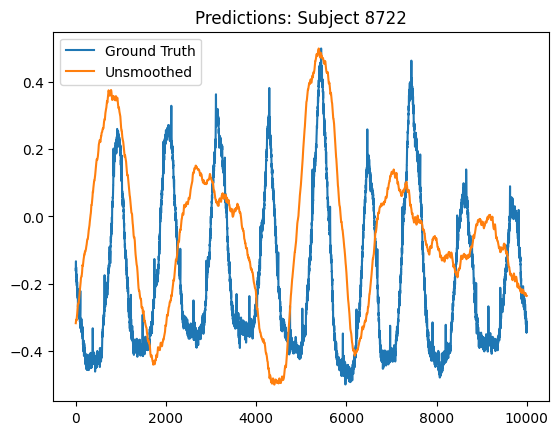

In [213]:
ecg_env = marsh_dataset[test_idx].ECG_ENV().transform(transforms=[
    Transforms.Crop(20, 20+10000//250),
    Transforms.MinMaxScale(),
    lambda x: -x+0.5
]).transformed_data
original_prediction = np.convolve(test_preds[:, 0], np.ones((500,))/500, mode='valid')[20*250:20*250+10000]
original_prediction = (original_prediction - original_prediction.min())/(original_prediction.max()-original_prediction.min()) - 0.5
# smoothed_pred = (smoothed_pred-smoothed_pred.min())/(smoothed_pred.max()-smoothed_pred.min()) - 0.5
gt = tsai_y_test[20*250:20*250+10000, 0]
gt = (gt-gt.min())/(gt.max()-gt.min()) - 0.5
plt.title(f"Predictions: Subject {subject_num}")
plt.plot(gt, '-', label='Ground Truth')
plt.plot(original_prediction, '-', label='Unsmoothed')
# plt.plot(ecg_env, label='envelope')
plt.legend()
plt.show()
smoothed_pred = Signal(format='mat', filepath=None, _type='ECG', data=smoothed_pred)
gt = Signal(format='mat', filepath=None, _type='ECG', data=gt)

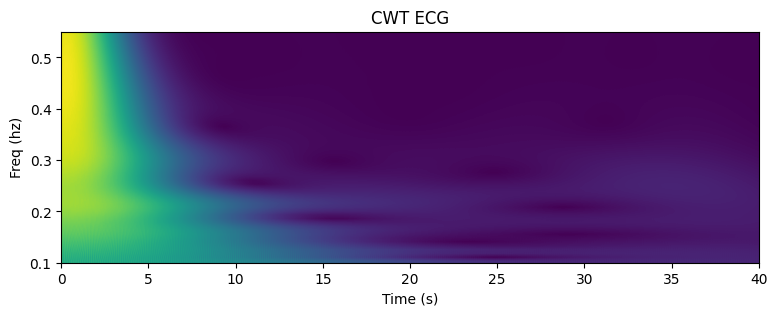

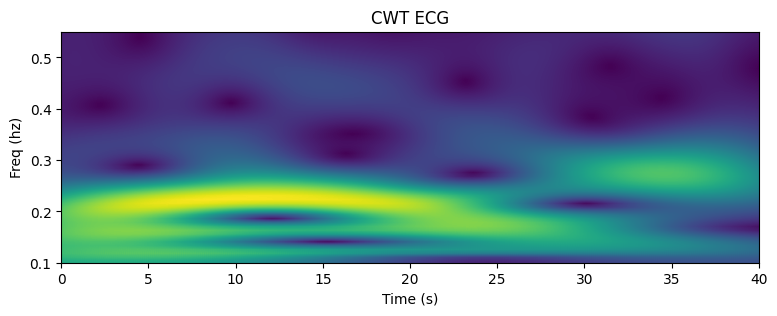

ValueError: up and down must be >= 1

In [124]:
t_test, PC_norms_test, PC_test = WPC(
    smoothed_pred.transform(transforms=[CWT]).transformed_data,
    gt.transform(transforms=[CWT]).transformed_data
    # freq=freq_band
)
print(f"| {sigma} | {0.0:.4f} | {PC_test.mean():.4f} |")

# Single Prediction Process

In [ ]:
# ECG input data
x_test_ecg_raw = marsh_dataset[test_idx].ECG().transform(transforms=[
    Transforms.Crop(start_time_XGB_test, start_time_XGB_test+N_test//marsh_dataset[test_idx].ECG().sample_rate),
    Transforms.MinMaxScale(),
    lambda x: x-x.mean(),
    lambda x: detrend(x),
]).transformed_data

x_test_ecg_rolling = get_rolling_windows(x_test_ecg_raw, window_size=window_size)

y_test = marsh_dataset[test_idx].IP().transform(transforms=[
    Transforms.Crop(start_time_XGB_test, start_time_XGB_test+N_test//marsh_dataset[test_idx].ECG().sample_rate),
    Transforms.MinMaxScale(),
    lambda x: x-x.mean(),
    lambda x: detrend(x),
]).transformed_data[window_size-1:]

print(x_test_ecg_rolling.shape, y_test.shape)
# Breathing Rate input and target data

preds = []
smoothed_preds = []
smoothing_length = 50
mean_filter = np.ones(smoothing_length)

for xi in tqdm(x_test_ecg_rolling):
    pred = reg.predict(xi[np.newaxis, :])[0]
    preds.append(
        pred
    )
    filt_order = min(smoothing_length, len(preds))
    smoothed_preds.append(
        np.dot(
            preds[-filt_order:],
            mean_filter[-filt_order:]
        )/filt_order
    )

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        y = preds, name='pred'
    )
)
fig.add_trace(
    go.Scatter(
        y = smoothed_preds, name='smoothed pred'
    )
)
fig.add_trace(
    go.Scatter(
        y = y_test, name='ground truth'
    )
)
fig.show()

# Figure showing Inst. Freq. process

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = np.arange(0, candA.shape[0]/250, 1/250),
        y = fantasia_dataset[i].ECG_ENV().transform(transforms=[
            crop,
            Transforms.MinMaxScale(),
            lambda x: x-x.mean()
        ]).transformed_data,
        name='Envelope and Interplotation'
    )
)
fig.add_trace(
    go.Scatter(
        x = np.arange(0, candA.shape[0]/250, 1/250),
        y = fantasia_dataset[i].ECG().transform(transforms=[
            crop,
            Transforms.MinMaxScale(),
            lambda x: x-x.mean()
        ]).transformed_data,
        name='ECG'
    )
)
fig.add_trace(
    go.Scatter(
        x = np.arange(0, candA.shape[0]/250, 1/250),
        y = fantasia_dataset[i].IP().transform(transforms=[
            crop,
            Transforms.MinMaxScale(),
            lambda x: x-x.mean()
        ]).transformed_data,
        name='IP'
    )
)
fig.update_layout(plot_bgcolor='white', width=800, height=500)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()